In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT/"src"))

# Startup checks
from config import RAW_FILE
from startup_checks import ensure_project_dirs, check_required_data

ensure_project_dirs()
check_required_data(RAW_FILE)

2025-12-19 17:10:14.974144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 17:10:15.035251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 17:10:16.208746: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from config import TEXT_COL, LABEL_COL, CLEAN_FILE, RANDOM_STATE, VOCAB_SIZE
from preprocess import load_and_clean_data
from utils import plot_confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
# load dataset
df = load_and_clean_data(RAW_FILE)    # df returned is label normalized and free of NaN, empty text row 
df.head()

# Export clean version dataset to data/processed
df.to_csv(CLEAN_FILE, index=False)

Function load_and_clean_data() performs:
- Load dataset with automatic encoding detection
- Drop rows with NaN text/label
- Remove rows with empty text
- Normalize labels (lowercase, remove single/double quotes, trim whitespace) [Optional]

In [4]:
# Display summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5842 non-null   object
 1   label   5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [5]:
count = df[LABEL_COL].value_counts()
percent = df[LABEL_COL].value_counts(normalize=True) * 100

result = (
    pd.DataFrame({"count": count, "percent": percent.map(lambda x: f"{x:.2f}%")}).reset_index(names=LABEL_COL)
)

result

,label,count,percent
0,neutral,3130,53.58%
1,positive,1852,31.70%
2,negative,860,14.72%


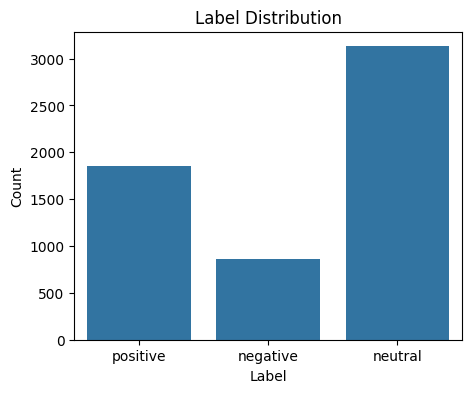

In [6]:
# Visualize class distribution
label_order = list(df[LABEL_COL].unique())

plt.figure(figsize=(5,4))
plt.title("Label Distribution")
sns.countplot(x=LABEL_COL, data=df, order=label_order)
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [7]:
# Text length statistics
df["text_length"] = df[TEXT_COL].apply(lambda sentence: len(sentence.split()))
length_stats = df["text_length"].describe()
percentile_95 = df["text_length"].quantile(0.95)

print(length_stats)
print(f"95% percentile = {percentile_95} words")

count    5842.000000
mean       21.004793
std        10.306465
min         2.000000
25%        13.000000
50%        19.000000
75%        27.000000
max        81.000000
Name: text_length, dtype: float64
95% percentile = 42.0 words


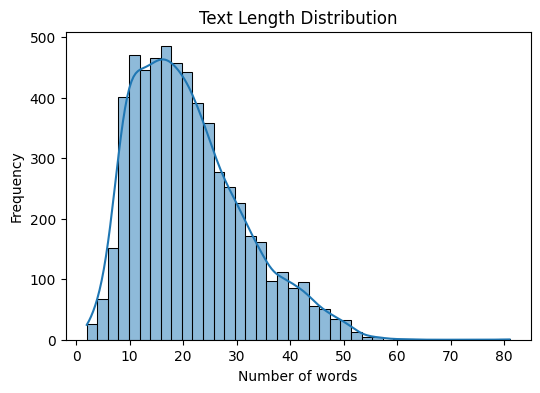

In [8]:
# Text length distribution
plt.figure(figsize=(6, 4))
sns.histplot(df["text_length"], bins=40, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Examples of Text and Label in dataframe
for i in range(5):
    print(f"[{df[LABEL_COL].iloc[i]} - {df[TEXT_COL].iloc[i]}\n]")

[positive - The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
]
[negative - $ESI on lows, down $1.50 to $2.50 BK a real possibility
]
[positive - For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
]
[neutral - According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .
]
[neutral - The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .
]


In [10]:
# Split dataset into train and test set
X = df[TEXT_COL]
y = df[LABEL_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,    # 70% train, 15% validation, 15% test
    stratify=y,    # keep same ratios of label classification
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.15/0.85,    # 70% train, 15% validation, 15% test
    stratify=y_train,
    random_state=RANDOM_STATE
)

print(f"Size of X_train = {len(X_train)} and Size of X_test = {len(X_test)}")

Size of X_train = 4088 and Size of X_test = 877


In [11]:
# Baseline - TF-IDF + Logistic Regression 
tfidf = TfidfVectorizer(
    max_features=VOCAB_SIZE,    
    ngram_range=(1, 2),    # Single word + 2-Word phrases
    stop_words="english"    # Remove meaningless common words
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

classifier = LogisticRegression(max_iter=1000, class_weight="balanced")
classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)
report = classification_report(y_test, y_pred)
print(report)

report = classification_report(y_test, y_pred, output_dict=True)
macro_f1_score = report['macro avg']['f1-score']

print(f"Baseline: macro F1-Score = {macro_f1_score:.4f}")

              precision    recall  f1-score   support

    negative       0.37      0.48      0.42       129
     neutral       0.76      0.74      0.75       470
    positive       0.73      0.67      0.70       278

    accuracy                           0.68       877
   macro avg       0.62      0.63      0.62       877
weighted avg       0.70      0.68      0.69       877

Baseline: macro F1-Score = 0.6244


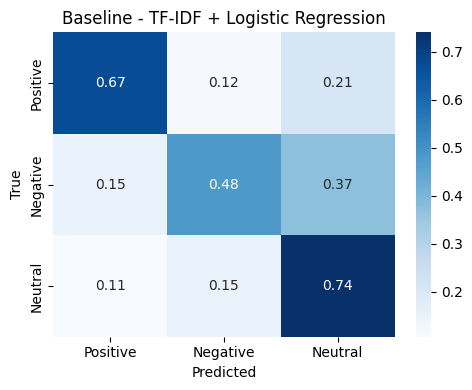

In [12]:
# Confusion matrix
title = "Baseline - TF-IDF + Logistic Regression"
plot_confusion_matrix(y_test, y_pred, labels=label_order, normalize="true", title=title)

## Summary - Exploratory Data Analysis & Classical Baseline (TF-IDF + Logistic Regression)

### Objective
Establish a strong and stable baseline for financial sentiment classification, and understand the dataset characteristics before applying neural models.

### Work performed
- Loaded and cleaned the Financial PhraseBank dataset (removed NaN, empty rows, normalize labels)
- Analyzed class imbalance and sentence length distribution
- Built a classical NLP baseline by **TF-IDF (1-2 grams) + Logistic Regression**

### Key decisions
- Evaluation metrics: Use macro F1-score due to class imbalance

### Results (baseline on test set)
- **Macro F1-score (test): 0.62**

### Artifacts produced
- Cleaned dataset for downstream modeling
- Baseline evaluation results for fair comparison with neural models
- Cleaned csv: **data/processed/financial_phrasebank_clean.csv**

### Takeaway
The TF-IDF baseline performs strongly on short, keyword-driven financial sentences, providing a competitive reference point for subsequent deep learning models.